# TP SD211: Nonnegative Matrix Factorization

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.sparse
import scipy.sparse.linalg

## 1. Database

In [4]:
def build_matrix_from_faces(folder='att_faces', minidata=False):
    # load images
    # 400 images of size (112, 92)
    M = []
    if minidata is True:
        nb_subjects = 1
    else:
        nb_subjects = 40
    for subject in range(1, nb_subjects + 1
                        ):
        for image in range(1, 11):
            face = plt.imread(folder + '/s' + str(subject)
                              + '/' + str(image) + '.pgm')
            M.append(face.ravel())

    return np.array(M, dtype=float)

def vectorize(W, H):
    return np.concatenate((W.ravel(), H.ravel()))

def unvectorize_M(W_H, M):
    # number of elements in W_H is (n+p)*k where M is of size n x m
    # W has the nk first elements
    # H has the kp last elements
    n, p = M.shape
    k = W_H.shape[0] // (n + p)
    W = W_H[:n * k].reshape((n, k))
    H = W_H[n * k:].reshape((k, p))
    return W, H

In [5]:
# Small data to test the algorithm
M = build_matrix_from_faces(folder='att_faces', minidata=True)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 2

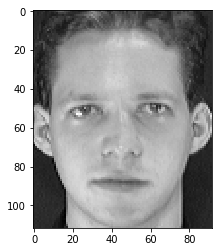

In [6]:
# To see the first face:
plt.imshow(M[0].reshape((112, 92)), cmap='gray'); plt.show()
# Full data
M = build_matrix_from_faces(folder='att_faces', minidata=True)

def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 3

In [152]:
n,p = M.shape # shape of M fixed for whole lab

#In the project we use the mini-data set for computation time's sake

print('Number of images: '+str(n))
print('Number of pixels per image: '+str(p))

Number of images: 10
Number of pixels per image: 10304


## 2. Presentation of the model

Let's find a counter example where the objective function is not convex. Let's fix n=p=k=1.

The objective function is $ f = \frac{1}{2}(m-wh)^{2}$

The Hessian Matrix of f is $\nabla^{2} f = \bigg{(}\begin{matrix}h^2 & 2wh-m \\ 2wh-m & w^2\end{matrix}\bigg{)} \\
$.

We get, 

$det \nabla^{2} f = -3(hw)^{2} -m^{2} +4mhw $. 

If we chose $m=1, h=1, w=-1, \: det \nabla^{2} f < 0$
which implies that f is not convex since it shows that $\nabla^{2} f $ has a negative eigenvalue. We have exhibited a case where the objective function is not convex, thus we cannot suppose that it is convex in a general case.



Now let's compute the gradient.  

$f(W+\delta W,H)= \frac{1}{2np} \Vert M-(W-\delta W)H\Vert^{2} \\ =\frac{1}{2np}( \Vert M-WH\Vert^{2} - 2\langle M-WH,\delta WH\rangle + o\Vert W \Vert^{2}) \\ = \frac{1}{2np}( \Vert M-W\Vert^{2} - 2\langle (M-WH)H^{t} , \delta W\rangle + o\Vert W \Vert^{2})
$

Thus we get that, 

$f(W+\delta W,H)-f(W,H) = -\frac{1}{np}\langle (M-WH)H^{t} , \delta W\rangle + o\Vert W \Vert^{2}$

and therefore,

$\frac{\partial f}{\partial W} = -\frac{1}{np}(M-WH)H^{t}$ 

Doing a similar differentiation for H, we get that 

$\nabla f(W,H) = \Bigg{\{}\begin{matrix}  \frac{\partial f}{\partial W} = -\frac{1}{np}(M-WH)H^{t} \\ \frac{\partial f}{\partial H} = -\frac{1}{np}W^{t}(M-WH) \end{matrix}$



## 3. Find $W$ when $H_{0}$ is fixed

### 3.1

In [21]:
# Initialisation
W0, S, H0 = scipy.sparse.linalg.svds(M, k)
W0 = np.maximum(0, W0 * np.sqrt(S))
H0 = np.maximum(0,(H0.T * np.sqrt(S)).T)

The advantage of this choice is that we are using another type of factorisation to approximate the solution. We thus assume that the two factorization techniques will yield close results. The computation will require less iterations if the initial matrixes are close to the solutions given by NMF. Other possibilities are to initialise at random or with a fixed W or H.

### 3.2

Let $W_{1}$ and $W_{2}$ be two $n \times k$ matrixes.
For $t \in (0,1):$

$ g\,(tW_{1}+(1-t)W_{2}) = \frac{1}{2np}\Vert ((t(M-W_{1})+(1-t)(M-W_{2}))H_{0}\Vert^{2} \leq \Vert t(M-W_{1})H_{0}\Vert^{2} + \Vert (1-t)(M-W_{2})H_{0}\Vert^{2} \\ \leq t\Vert (M-W_{1})H_{0}\Vert^{2} + (1-t)\Vert(M-W_{2})H_{0}\Vert^{2} = tg(W_{1})+(1-t)g(W_{2})$

$g$ satisfies the convex inequality, thus $g$ is convex.

$\nabla\,g(W) = -\frac{1}{np}(M-WH_{0})H_{0}^{t}$

### 3.3

In [22]:
def val_g(W): #Computes the value of g(W)
    WH0=np.dot(W,H0)
    return 1/(2*n*p)*np.linalg.norm(M-WH0,ord='fro')**2

def grad_g1(W,H): #Computes the value of grad g(W) but with 2 arguments (easier for implementation). 
    return (-1/(n*p)*np.dot(M-np.dot(W,H),H.T))

def val_vect_g(W_vec): #computes the value of g(W) with W vectorized (for scipy)
    Wp = W_vec.reshape((n,k))
    return val_g(Wp).ravel()
    
def grad_vect_g(W_vec): #computes the value of grad g(W) with W vectorized (for scipy)
    W = W_vec.reshape((n,k))
    return grad_g(W).ravel()

In [23]:
print(scipy.optimize.check_grad(val_vect_g, grad_vect_g, W0.ravel()))

3.875046240706016e-05


Such a low value comforts us into thinking that our gradient seems to be correct.

### 3.4

Let $x$ be in $\mathbb{R}_{+}$

$prox_{ \gamma \iota_{\mathbb{R}_{+}}}(x) = \underset{y \in \mathbb{R}}{argmin} \, \,  \iota_{\mathbb{R}_{+}}(y) + \frac{1}{2\gamma}\Vert x-y \Vert^{2}$

To be a minimum of this function, $y$ must be in $\mathbb{R}_{+}$, otherwise the function is worth $+\infty$.

So we have: 

$prox_{ \gamma \iota_{\mathbb{R}_{+}}}(x) = \underset{y \in \mathbb{R}_{+}}{argmin} \, \,  \frac{1}{2\gamma}\Vert x-y \Vert^{2} = \underset{y \in \mathbb{R}_{+}}{argmin} \, \,  \Vert x-y \Vert^{2} $

Which is the definition of the projection of $x$ on $\mathbb{R}_{+}$


In [144]:
def proj(M): #proximal operator
    return np.maximum(0,M)

#returns unidimensional optimisation of W with H fixed with constant step

def projected_gradient_method(val_g, grad_g1, H,W, gamma, N): 
    c=0
    Wo = W
    while c < N:
        Wo = proj(Wo-gamma*(grad_g1(Wo,H)))
        c+=1
    return Wo

In [128]:
#determination of the step
L0= np.linalg.norm(np.dot(H0.T,H0),ord='fro')
gamma0=n*p/L0

## 4. Algorithmic refinement with $H_{0}$ fixed

We are going to implement a Taylor line search to determine at each iteration the right value of the step.

In [81]:
def taylor_line_search(func,grad,gamma,H0,W0,optimiseH=False): #returns step found with the taylor line search algorithm
    if optimiseH:

# initialisation of the step        
        a=0.5 
        b= 2*gamma
        gammak = b
        X = H0-gammak*grad(H0,W0)
 
        while func([W0,X]) > func([W0,X]) -(1/2)*gammak*(np.linalg.norm(grad(H0,W0)))**2: #taylor condition so that f decreases
            gammak = gammak*a
            X = H0-gammak*grad(H0,W0)
        return gammak
    
    else:
        a=0.5
        b= 2*gamma
        gammak = b
        X = W0-gammak*grad(W0,H0)
        while func([X,H0]) > func([X,H0]) -(1/2)*gammak*(np.linalg.norm(grad(W0,H0)))**2:
            gammak = gammak*a
            X= W0-gammak*grad(W0,H0)
        return gammak



In [151]:
#returns unidimensional optimisation of H (resp. W) with W (resp. H) fixed with line search
def line_search_projection_gradient_method(val_f, grad_g1, H,W, gamma0, N, optimiseH=False): 
    if optimiseH:
        c=0
        Ho=H
        gamma = gamma0
        while c < N:
            Ho = proj(Ho-gamma*(grad_h(Ho,W)))
            gamma = taylor_line_search(val_f,grad_h,gamma,Ho,W,optimiseH=True)
            c +=1
        return Ho


    else:
        c=0
        Wo = W
        gamma = gamma0
        while c < N:
            Wo = proj(Wo-gamma*(grad_g1(Wo,H)))
            gamma = taylor_line_search(val_f,grad_g1,gamma,H,Wo)
            c +=1
        return Wo



In [132]:
#performances
import time

print ("Intial value of objective function = "+str(val_g(W0)))

display('Constant Step:')
begin = time.time()
W1 = projected_gradient_method(val_g,grad_g1,H0,W0,gamma0,100)
end = time.time()

print("Execution time with constant step = "+str(end-begin))
print('g(W) = '+str(val_f([W1,H0])))

display('Taylor Line Search:')
begin = time.time()
W2 = line_search_projection_gradient_method(val_f,grad_g1,H0,W0,gamma0,100)
end = time.time()

print("Execution time with taylor line search = "+str(end-begin))
print('g(W) = '+str(val_f([W2,H0])))


Intial value of objective function = 416.80820665867685


'Constant Step:'

Execution time with constant step = 0.0462191104888916
g(W) = 393.366955931801


'Taylor Line Search:'

Execution time with taylor line search = 0.4645719528198242
g(W) = 400.88717579382995


The constant step method has better performances because there is no need to compute the appropriate step at each iteration, both of them yield comparable values for the objective function. This is because we already have a good idea of the step we need to use in the projected gradient descent as we have knowledge of $L_{0}$. If we didn't know this constant, the value of the objective function in the second algorithm will probably be much better. Furthermore, we could gain execution time for the taylor line search by using scipy.optimize.linesearch which will compute the appropriate step faster than our iterative algorithm or we could use the exact line search method and compute the real value of the step at each iteration. 

In [146]:
display(W1) #result with constant step

array([[ 0.        ,  0.        , 64.3604483 ],
       [ 0.        ,  0.        , 70.75177521],
       [ 0.        ,  0.        , 65.94946631],
       [39.14049561, 30.73649672, 62.47215824],
       [ 0.        , 24.63928947, 67.56691955],
       [52.61955074,  0.        , 64.32136502],
       [10.47242422,  0.        , 65.93969336],
       [ 0.        , 19.14975815, 63.08883329],
       [ 0.        , 58.37480551, 60.44105193],
       [ 0.        ,  8.5181865 , 65.10525922]])

In [145]:
display(W2) #result with line search

array([[ 0.36016337,  0.        , 64.29315903],
       [ 0.        ,  0.        , 70.75177521],
       [ 0.        ,  0.        , 65.94946631],
       [32.15747636, 21.06943013, 64.30858063],
       [ 0.        , 14.05699013, 68.85099269],
       [39.87640858,  0.        , 65.57925827],
       [12.45812751,  0.        , 65.76955381],
       [ 0.        , 21.84628874, 62.79147543],
       [ 0.        , 35.09444909, 63.27082171],
       [ 0.        , 10.8862681 , 64.83438076]])

We see that the results are similar, both algorithms seem to be effective

## 5. Resolution of the full problem

### 5.1

First we define new functions that take into account the fact that H is not fixed anymore.

Similarly to the definition of g, let h be the function such that, 

$\forall H, \, h(H)= \frac{1}{2np} \Vert M-WH\Vert^{2}$

In [ ]:
def val_f(WH): #returns the value of objective function
    W=WH[0]
    H=WH[1]
    W_H=np.dot(W,H)
    return 1/(2*n*p)*np.linalg.norm(M-np.dot(W,H),ord='fro')**2


def grad_f(WH): #returns the gradient of objective function
    W=WH[0]
    H=WH[1]
    a = (-1/(n*p)*np.dot(M-np.dot(W,H),H.T)) #grad // W
    b = (-1/(n*p)*np.dot(W.T,M-np.dot(W,H))) #grad // H
    return a,b

def grad_h(H,W):
    return (-1/(n*p)*np.dot(W.T,M-np.dot(W,H))) #grad // H


#finds the step with taylor line search algorithm for the full problem
def taylor_line_search_full(func,grad_f,grad_g,grad_h,gamma,WH): 
    a=0.5
    b= 2*gamma
    gammak = b
    W =WH[0]
    H =WH[1]
    X1 = W-gammak*grad_g1(W,H)
    X2 = H-gammak*grad_h(H,W)
    while func([X1,X2]) > func([W,H]) -(1/2)*gammak*((np.linalg.norm(grad_h(H,W)))**2 + (np.linalg.norm(grad_g1(W,H)))**2):
        gammak = gammak*a
        X1 = W-gammak*grad_g1(W,H)
        X2 = H-gammak*grad_h(H,W)

        return gammak

In [134]:
#projected gradient method for full problem

def projected_gradient_method_full(val_f, grad_f,grad_g1,grad_h, W, H, gamma0, N):
    c=0
    Wo = W
    Ho = H
    gamma = gamma0
    while c < N:
        grad=grad_f([Wo,Ho])
        Wo = proj(Wo-gamma*(grad[0]))
        Ho = proj(Ho-gamma*(grad[1]))
        gamma = taylor_line_search_full(val_f,grad_f,grad_g1, grad_h,gamma,[Wo,Ho])
        c +=1
    
    return Wo,Ho


    

In [135]:
taylor_line_search_full(val_f,grad_f,grad_g1,grad_h,gamma0,(W0,H0))

1.100630634860616

In [138]:
W3,H3 = projected_gradient_method_full(val_f,grad_f,grad_g1,grad_h,W0,H0,gamma0,1000)

print("Objective function before full line search projected gradient = "+str(val_f([W0,H0])))
print("Objective function after full line search projected gradient = "+str(val_f([W3,H3])))

display(W3,H3)

Objective function before full line search projected gradient = 416.80820665867685
Objective function after full line search projected gradient = 254.51340168899387


array([[35.51293413,  4.087492  , 58.2437089 ],
       [ 5.95712418,  6.75796484, 89.38289536],
       [30.67135781,  0.        , 68.04112361],
       [66.39015642, 51.79744803,  0.        ],
       [ 3.53837394, 55.77010903, 49.38165549],
       [85.74737169,  8.73802959, 19.58219581],
       [48.75768947, 17.05992876, 39.90915475],
       [17.50690698, 62.24594709, 25.14150377],
       [18.67910471, 77.95717562, 13.60368703],
       [ 0.        , 50.09563045, 51.17018937]])

array([[0.39912811, 0.40039978, 0.26613059, ..., 1.10861882, 0.93295823,
        1.11533939],
       [0.43955169, 0.41496467, 0.35813546, ..., 0.1730058 , 0.13328859,
        0.08542833],
       [0.50076169, 0.56586816, 0.65279161, ..., 0.22922647, 0.31982677,
        0.27393861]])

The algorithm returns W and H corresponding to the nmf factorization of M where both W and H were optimised simultaniously. 

### 5.2

First we have that: 

$ \forall H, f(W_{t},H_{t}) \leq f(W_{t},H)$ 

In particular we have $f(W_{t},H_{t}) \leq f(W_{t},H_{t-1}).$

Next, we have that:

$ \forall W, f(W_{t},H_{t-1}) \leq f(W,H_{t-1})$ 

In particular we have $f(W_{t},H_{t-1}) \leq f(W_{t-1},H_{t-1}).$

By combining what we have shown above, we get that:

$ f(W_{t},H_{t}) \leq f(W_{t-1},H_{t-1})$
The objective function decreases at every iteration. Since $f \geq 0$ and $ \big{(} \, f(W_{t},H_{t})\big{)}_{t\geq 1}$ decreases, we get that the value converges by the monotone covergence theorem. 



### 5.3

In [147]:
# alternative minimistion method
def alternative_minimization(val_f,grad_g1,grad_h,H,W,gamma0,N):
    c=0
    while c < N:
        W = line_search_projection_gradient_method(val_f,grad_g1,H,W,gamma0,100)
        H = line_search_projection_gradient_method(val_f, grad_h,H,W,gamma0,100,optimiseH=True)
        c+=1
    
    return W,H

### 5.4

In [150]:
print("Initial value of the objective function  = "+str(val_f([W0,H0])))

begin = time.time()
W4,H4 = projected_gradient_method_full(val_f,grad_f,grad_g1,grad_h,W0,H0,gamma0,100)
end = time.time()

display('Projected Gradient Method:') 

print("Objective Function = "+str(val_f([W4,H4])))
print("Execution time  = "+str(end-begin))

begin = time.time()
W5,H5 = alternative_minimization(val_f,grad_g1,grad_h,H0,W0,gamma0,100)
end = time.time()

display('Alternative Minimization:') 

print("Objective Function = "+str(val_f([W5,H5])))
print("Execution time' = "+str(end-begin))





Initial value of the objective function  = 416.80820665867685


'Projected Gradient Method:'

Objective Function = 264.9252804062315
Execution time  = 0.8353631496429443


'Alternative Minimization:'

Objective Function = 271.12049912896697
Execution time' = 97.65426683425903


In [148]:
display(W4,H4) 

array([[15.28217183,  0.        , 70.90174102],
       [18.75592555,  0.        , 77.10073877],
       [15.22876028,  0.        , 72.97585907],
       [49.44771115, 51.12487412, 31.28058347],
       [ 4.43932985, 47.04427419, 53.93067086],
       [69.21203291,  7.51647557, 48.99736566],
       [31.44270192, 13.05355068, 59.0233721 ],
       [ 0.        , 53.55064927, 45.71573517],
       [ 2.39320734, 73.27373546, 34.88446045],
       [ 0.        , 36.93213927, 57.01371926]])

array([[0.29659046, 0.26812018, 0.05403851, ..., 1.35084443, 1.06623926,
        1.3580681 ],
       [0.38876907, 0.33999052, 0.23984438, ..., 0.2431093 , 0.13681721,
        0.13391951],
       [0.56003253, 0.63053368, 0.71716094, ..., 0.27374524, 0.37979513,
        0.31114656]])

In [149]:
display(W5,H5)

array([[5.69379709e-01, 0.00000000e+00, 6.46698123e+01],
       [0.00000000e+00, 0.00000000e+00, 7.10318743e+01],
       [0.00000000e+00, 0.00000000e+00, 6.63581546e+01],
       [3.54077491e+01, 2.32072733e+01, 6.28327124e+01],
       [0.00000000e+00, 1.63273109e+01, 6.84709685e+01],
       [4.41348695e+01, 0.00000000e+00, 6.46236845e+01],
       [1.38541383e+01, 0.00000000e+00, 6.56399318e+01],
       [0.00000000e+00, 2.27533329e+01, 6.24641153e+01],
       [2.07011892e-02, 3.86326290e+01, 6.21169507e+01],
       [0.00000000e+00, 1.17114903e+01, 6.48379069e+01]])

array([[0.02827974, 0.01535327, 0.        , ..., 1.22025258, 0.90800333,
        1.20866584],
       [0.05392474, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.72185606, 0.76223704, 0.72828496, ..., 0.59122033, 0.59065003,
        0.58110282]])

The projected gradient with linesearch method gives both a better value for the objective function and is executed much faster. The alternative minimisation takes more than a hundred times the time of the projected gradient algorithm's execution time. This is normal since each iteration constitutes 200 iterations of the unidimensional linesearch method. Despite the number of iterations, it disapointingly does not yield a better value for the objective function. 

Also, we see the resulting matrixes are quite different, but there is no real way to say which factorisation is better without looking at the objective function. 

### 5.5

We could use a criterion on the step. 
There are many different ways to do this. 

One of them could be:  if $\Vert(W_{t}-W_{t-1},H_{t}-H_{t-1})\Vert \leq \alpha $ where $ \alpha$ is chosen by the user, the algorithm stops. We can decide to apply this criteria only on H or only on W. 


We could also use a criterion on the cost function, where the algorithm stops if $f(W_{t},H_{t}) - f(W_{t-1},H_{t-1}) \leq \epsilon$ where the user fixes $\epsilon$.  

In both cases the criterion stops the algorithm when the algorithm is likely to be close to convergence (convergence of W and H in the first case, and convergence of the objective function in the later.